# Testing the effect of a price increase on Company XYZ’s revenue

(This work is originally a mock data challenge completed as part of the 2020A Boston Insight Data Science Fellows Program. This work was finished within 4 hours limit. )

## Executive Summary

The goal of this project is to generate insights from an A/B testing running on the site for a software product. The responses of these customers, as well as those of a control group shown the normal software price, were recorded along with some other information over a period of three months.

**Key questions addressed by this project**:

- What is the impact on conversion rate due to increasing the price of the software?
- What is the impact on revenue due to increasing the price of the software?
- Can A/B testing be made more efficient in the future? Could we have stopped collecting data earlier being able to get statistically significant results?


**The project is organized into several sections**:

- Load Datasets
- Data Processing and Cleaning
- EDA
- Testing differences between control group and test group
- Conclusion and key insights


In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats import weightstats as sms # for ztest
import re
from sklearn.preprocessing import OneHotEncoder

## Load Datasets

In [2]:
user_df = pd.read_csv('user_table.csv')
user_df.head()

,user_id,city,country,lat,long
0,510335,Peabody,USA,42.53,-70.97
1,89568,Reno,USA,39.54,-119.82
2,434134,Rialto,USA,34.11,-117.39
3,289769,Carson City,USA,39.15,-119.74
4,939586,Chicago,USA,41.84,-87.68


In [3]:
user_df.info()
user_df.isnull().sum() # check for missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275616 entries, 0 to 275615
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  275616 non-null  int64  
 1   city     275616 non-null  object 
 2   country  275616 non-null  object 
 3   lat      275616 non-null  float64
 4   long     275616 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 10.5+ MB


user_id    0
city       0
country    0
lat        0
long       0
dtype: int64

In [4]:
test_df = pd.read_csv('test_results.csv')
test_df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0
1,624057,2015-05-10 21:08:46,seo-google,mobile,android,0,39,0
2,317970,2015-04-04 15:01:23,ads-bing,mobile,android,0,39,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0


In [5]:
test_df.info()
test_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316800 entries, 0 to 316799
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   user_id           316800 non-null  int64 
 1   timestamp         316800 non-null  object
 2   source            316800 non-null  object
 3   device            316800 non-null  object
 4   operative_system  316800 non-null  object
 5   test              316800 non-null  int64 
 6   price             316800 non-null  int64 
 7   converted         316800 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 19.3+ MB


user_id             0
timestamp           0
source              0
device              0
operative_system    0
test                0
price               0
converted           0
dtype: int64

## Data Processing and Cleaning

In [6]:
test_df['source'].value_counts()

direct_traffic     60357
ads-google         59379
ads_facebook       53396
ads_other          29876
seo-google         23175
ads-bing           22873
seo_facebook       21205
friend_referral    20695
seo-other           9260
ads-yahoo           7583
seo-yahoo           6848
seo-bing            2153
Name: source, dtype: int64

In [7]:
test_df['device'].value_counts()

mobile    186471
web       130329
Name: device, dtype: int64

In [8]:
test_df['operative_system'].value_counts()

windows    100976
iOS         95465
android     74935
mac         25085
other       16204
linux        4135
Name: operative_system, dtype: int64

In [9]:
test_df['price'].value_counts()

39    202672
59    114128
Name: price, dtype: int64

In the source column there isn't standardization between dash and underscore instances: change them all to underscores for consistency

In [10]:
# fix - and _ issue
test_df['source'] = test_df['source'].str.replace('-', '_')

I will join the two tables on 'user_id', but first I need to check to make sure there are no duplicates in user_id (in this case, the same user would buy the software twice). 

In [11]:
user_df[user_df.duplicated(subset=['user_id'])]

,user_id,city,country,lat,long


In [12]:
test_df[test_df.duplicated(subset=['user_id'])]

,user_id,timestamp,source,device,operative_system,test,price,converted


Good news is that 'user_id' is not duplicated for both tables, so I can directly join them.

In [13]:
# merge test_results with user_table
df = pd.merge(left=test_df, right=user_df, how='left', on='user_id')
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86
1,624057,2015-05-10 21:08:46,seo_google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24
2,317970,2015-04-04 15:01:23,ads_bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02


The 'price' should match the 'test', i.e.
- all test result 0 should correspond to price 39
- all test result 1 should correspond to price 59
<br>
However, is this true?

In [14]:
df[['price', 'test', 'user_id']].groupby(['price','test']).count()

user_id
price test         
39    0      202517
      1         155
59    0         210
      1      113918

It seems there are some problems with the data:
- 155 users whose test results are labelled 1 fall into price 39
- 210 users whose test results are labelled 0 fall into price 59
<br>
Since these are only a small portion in the whole dataset, I am going to remove these problematic rows.

In [15]:
df.drop(df[(df['test']==1)&(df['price']==39)].index,inplace=True)
df.drop(df[(df['test']==0)&(df['price']==59)].index,inplace=True)

In [16]:
df.shape

(316435, 12)

In [17]:
# create new column called revenue
df['revenue'] = df['converted'] * df['price']
df.head()

,user_id,timestamp,source,device,operative_system,test,price,converted,city,country,lat,long,revenue
0,604839,2015-05-08 03:38:34,ads_facebook,mobile,iOS,0,39,0,Buffalo,USA,42.89,-78.86,0
1,624057,2015-05-10 21:08:46,seo_google,mobile,android,0,39,0,Lakeville,USA,44.68,-93.24,0
2,317970,2015-04-04 15:01:23,ads_bing,mobile,android,0,39,0,Parma,USA,41.38,-81.73,0
3,685636,2015-05-07 07:26:01,direct_traffic,mobile,iOS,1,59,0,Fayetteville,USA,35.07,-78.90,0
4,820854,2015-05-24 11:04:40,ads_facebook,web,mac,0,39,0,Fishers,USA,39.95,-86.02,0


## EDA
### Divide control and test groups and check their randomness

Before we dive into the analysis, it's critical to make sure that the testing and training samples are similar to one another in order to control for variables like time distributions, device choice, etc.
<br>
It's important to check whether datapoints are indeed assigned randomly to the control and test groups. 
<br>
The statistical test for this, since we are testing two categorical datasets, is Chi-squared, but it can be informative to just give the distributions a quick look to see if they are the same. 

In [18]:
# dates go from March 2015 through May 2015
df['timestamp'] = df['timestamp'].apply(lambda x: re.sub('60', '00', x)) 
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['date'] = df['timestamp'].dt.date
print('Min date: ' + format(df['date'].min() ))
print('Max date: ' + format(df['date'].max() ))
delta = df['date'].max() - df['date'].min()
print(delta)

Min date: 2015-03-02
Max date: 2015-05-31
90 days, 0:00:00


Now I know the test went from March to May and lasted for 90 days. 

In [19]:
#Divide control and test groups
df_control = df[df['test']==0]
df_test = df[df['test']==1]

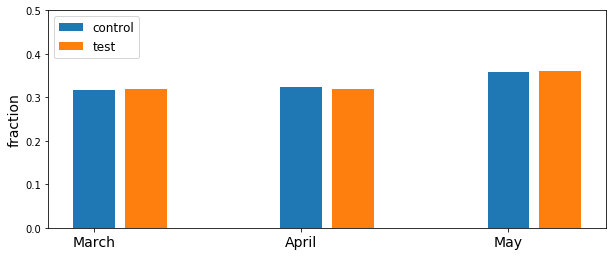

In [20]:
grouped_by_month_control = df_control['timestamp'].groupby(df_control['timestamp'].dt.month).count()
grouped_by_month_control = grouped_by_month_control/sum(grouped_by_month_control)

grouped_by_month_test = df_test['timestamp'].groupby(df_test['timestamp'].dt.month).count()
grouped_by_month_test = grouped_by_month_test/sum(grouped_by_month_test)

x1 = [1, 5, 9]
x2 = [2, 6, 10]
fig, ax = plt.subplots(figsize=(10,4))
plt.bar(x1, grouped_by_month_control, label='control')
plt.bar(x2, grouped_by_month_test, label='test')
plt.xticks(x1, ('March', 'April', 'May'), fontsize=14)
plt.ylabel('fraction', fontsize=14)
plt.legend(loc=2, fontsize=12)
plt.ylim([0.0, 0.5])
plt.show()

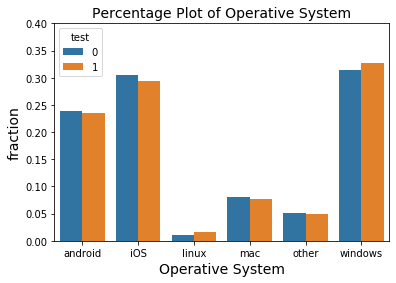

In [21]:
# Visualization of operative system
count = df[['operative_system', 'test', 'revenue']].groupby(['operative_system', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / count.loc[count['test'] == 1, 'revenue'].sum()
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / count.loc[count['test'] == 0, 'revenue'].sum()

sns.barplot(x='operative_system', y='revenue', hue='test', data=count)
plt.xlabel('Operative System', fontsize=14)
plt.ylabel('fraction', fontsize=14)
#plt.legend(['control'])
plt.title('Percentage Plot of Operative System', fontsize=14)
plt.ylim([0.0, 0.4])
plt.show()

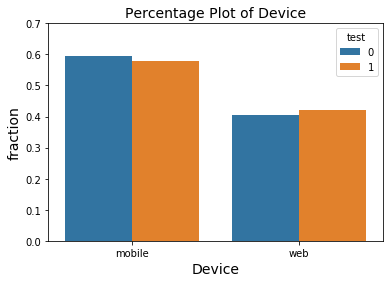

In [22]:
# Visualization of device
count = df[['device', 'test', 'revenue']].groupby(['device', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / count.loc[count['test'] == 1, 'revenue'].sum()
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / count.loc[count['test'] == 0, 'revenue'].sum()

sns.barplot(x='device', y='revenue', hue='test', data=count)
plt.xlabel('Device', fontsize=14)
plt.ylabel('fraction', fontsize=14)
#plt.legend(['control'])
plt.title('Percentage Plot of Device', fontsize=14)
plt.ylim([0.0, 0.7])
plt.show()

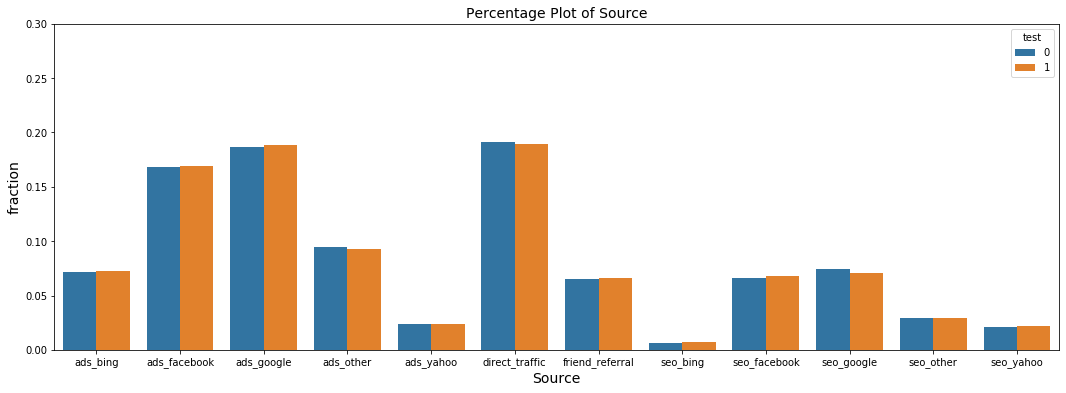

In [23]:
# Visualization of source
count = df[['source', 'test', 'revenue']].groupby(['source', 'test']).count().reset_index()
count.loc[count['test'] == 1, 'revenue'] = count.loc[count['test'] == 1, 'revenue'] / count.loc[count['test'] == 1, 'revenue'].sum()
count.loc[count['test'] == 0, 'revenue'] = count.loc[count['test'] == 0, 'revenue'] / count.loc[count['test'] == 0, 'revenue'].sum()

plt.figure(figsize=(18,6))
sns.barplot(x='source', y='revenue', hue='test', data=count)
plt.xlabel('Source', fontsize=14)
plt.ylabel('fraction', fontsize=14)
#plt.legend(['control'])
plt.title('Percentage Plot of Source', fontsize=14)
plt.ylim([0.0, 0.3])
plt.show()

From the above plots, I can confirm that our control and test sets do not appear to be systematically biased when compared with one another.

## Testing differences between control group and test group

### Testing conversion rate differences

In [24]:
# check the conversion rate for A/B test
df[['test', 'converted']].groupby('test').describe()

converted                                             
         count      mean       std  min  25%  50%  75%  max
test                                                       
0     202517.0  0.019900  0.139656  0.0  0.0  0.0  0.0  1.0
1     113918.0  0.015555  0.123747  0.0  0.0  0.0  0.0  1.0

- The conversion rate for control group (\$39) is 0.0199
- The conversion rate for test group (\$59) is 0.0156
<br>
This looks like a very small difference in conversion rate, but since the overall conversion rate is small it's actually a difference of 21.8% ((0.0199-0.0156)/0.0199=21.8%). But how significant is the difference?
<br>
Now, let's conduct hypothesis testing.

- Null hypothesis H0: experimental group's average conversion rate is equal to or less than control group's average conversion rate
- Alternative hypothesis H1: experimental group's average conversion rate is higher than control group's average conversion rate

Since the samples size is very large, I am going to conduct a z-test to see how significant the difference is.

In [60]:
sms.CompareMeans.from_data(df_control['converted'], df_test['converted']).\
ztest_ind(alternative='two-sided', usevar='unequal', value=0)

(9.044608417898447, 1.502025446569963e-19)

Pvalue is very small, approaching zero. Thus we can reject our null hypothesis with a high degree of confidence, i.e., at greater than 99.99% confidence level, we can rule out the conversion rates being the same.

### Testing revenue differences

In [26]:
# check the revenue for A/B test
df[['test', 'revenue']].groupby('test').describe()

revenue                                              
         count      mean       std  min  25%  50%  75%   max
test                                                        
0     202517.0  0.776083  5.446566  0.0  0.0  0.0  0.0  39.0
1     113918.0  0.917748  7.301050  0.0  0.0  0.0  0.0  59.0

The table shows that the average revenue for higher price $\$0.918$
is actually larger than the lower price \$0.776, leading to an increase of 18%. This means that although we lost some customers due to rising price, but the overall revenue did increase.
<br>
<br>
Now, let's conduct hypothesis testing.

- Null hypothesis H0: experimental group's average revenue is equal to or less than control group's average revenue
- Alternative hypothesis H1: experimental group's average revenue is higher than control group's average revenue

In [48]:
sms.CompareMeans.from_data(df_control['revenue'], df_test['revenue']).\
ztest_ind(alternative='two-sided', usevar='unequal', value=0)

(-5.71522466646319, 1.0955917887326811e-08)

The p value is very small, indicating that there is huge significance. Now we can safely reject the null hypothesis, and conclude that experimental group's average revenue is higher than control group's average revenue.
<br>
However, sine p is essentially 0, it makes sense to further look into the relationship between p value and time, to see whether we could have stopped our A/B testing earlier to have the same level of confidence level.

### p value vs time

In [49]:
pvals = []
for i in pd.date_range(min(df_test['date']),max(df_test['date'])):
    data1 = df_test[df_test['date']<=i]['revenue']
    data2 = df_control[df_control['date']<=i]['revenue']
    pvals.append(sms.CompareMeans.from_data(data1, data2).\
ztest_ind(alternative='two-sided', usevar='unequal', value=0)[1])

In [50]:
pvals

[0.5151761070977627,
 0.921592788782724,
 0.47945011383103675,
 0.7785982607720914,
 0.20471389467026957,
 0.039928565990300736,
 0.03127550232716354,
 0.02836298326738482,
 0.03497500515192977,
 0.020106441993540062,
 0.014452073191677257,
 0.005703792895054952,
 0.0008867207864415892,
 0.000650559300602958,
 0.0019918883821791735,
 0.004370254250095467,
 0.005034092924635855,
 0.002471999347109042,
 0.0008099989024051361,
 0.00014005149626004012,
 9.762954443030585e-05,
 7.021103078996947e-05,
 5.087411597589867e-05,
 6.089930567155686e-05,
 0.00010934936081125118,
 7.764097888079719e-05,
 8.686573678166361e-05,
 1.6666558177037363e-05,
 1.7959552574181533e-05,
 2.0210945425152558e-05,
 3.2651020568979865e-05,
 1.596499300493417e-05,
 5.497659845042275e-05,
 3.094209898491008e-05,
 4.517354529788002e-05,
 1.9925983514789338e-05,
 1.1953293027301455e-05,
 1.591238515752925e-05,
 3.546145733221852e-05,
 1.2519743752348154e-05,
 1.6157677451148897e-05,
 2.415032042908328e-05,
 3.5734516

In [58]:
print(np.where(np.array(pvals)<0.001)[0][0])

12


Note that I chose the threshold of 0.001 here for cutting p-value because that means it is statistically highly significant (less than one in a thousand chance of being wrong).

In [53]:
date_range = pd.date_range(min(df_test['date']),max(df_test['date']))
date_range[12]

Timestamp('2015-03-14 00:00:00', freq='D')

So on March 14th 2015, pvalue became less than the critical point 0.05, which translates to 12 days. We might want to make it a two-week timeframe, taking weekends into consideration (sales volumes during weekends might have an impact). 

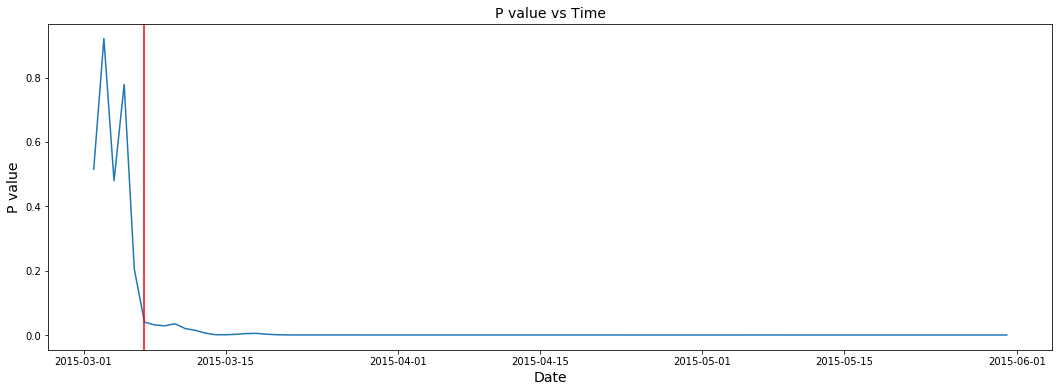

In [54]:
plt.figure(figsize=(18,6))
plt.xlabel('Date', fontsize=14)
plt.ylabel('P value', fontsize=14)
#plt.legend(['control'])
plt.title('P value vs Time', fontsize=14)
plt.plot(date_range,pvals)
plt.axvline(x=date_range[5], color='Red')

## Conclusion and key insights

To sum up, I conducted a followup analysis of an A/B test which was designed to determine the effects of increasing the price of a software product.
<br>

**Key insights**:

- Effects of increasing the price on conversion rate. Increasing the software price decreased conversion rate over the test period by 21.8% at (>99.99%) confidence level. If the higher price is adopted, further analysis is needed to make sure this price change doesn't result in steadily declining sales over the long term.

- Effects of increasing the price on revenue. Altough conversion rate decreased by 21.8%, net revenue per test user actually increased by 18% at a (>99.99%) confidence level, due to the higher price of the software.

- A/B testing could have been stopped earlier. My study of p-value vs time shows that a high level of confidence (99.7%) could have been reached with approximately 2 weeks of data collection instead of 3 months. I would suggest that we first define the goals of the A/B test and a level of significance desired, then we design the test to meet those objectives.